In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-set/BTC-USD (2).csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("/kaggle/input/data-set/BTC-USD (2).csv")

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df = data.reset_index()['Close']

In [6]:
df.head()

0    457.334015
1    424.440002
2    394.795990
3    408.903992
4    398.821014
Name: Close, dtype: float64

In [7]:
df

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
3097    20632.410156
3098    22163.949219
3099    24197.533203
3100    24746.074219
3101    24830.617188
Name: Close, Length: 3102, dtype: float64

In [8]:
length = len(df)
length

3102

In [9]:
bit_data = []
for i in range(10):
    bit_data.append(df[i])
    
for i in range(10,len(df)):
    sumof = 0
    for j in range(1,11,1):
        sumof += df[i-j]
    bit_data.append(sumof/10)
    

In [10]:
import matplotlib.pyplot as plt

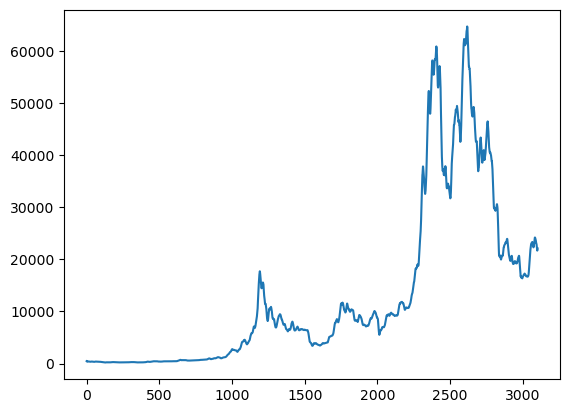

In [11]:
plt.plot(bit_data)


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
bit_data =  scaler.fit_transform(np.array(bit_data).reshape(-1,1))
bit_data =  scaler.fit_transform(np.array(df).reshape(-1,1))

In [13]:
bit_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.35643099],
       [0.36457095],
       [0.3658255 ]])

In [14]:
bit_data.shape

(3102, 1)

In [15]:
# splitting the data set into train and test data
training_size = int(len(bit_data)*0.80)
test_size = len(bit_data) - training_size
train_data, test_data = bit_data[:training_size,:], bit_data[training_size:len(bit_data),:1]

In [16]:
train_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.51733777],
       [0.49554305],
       [0.50036477]])

In [17]:
len(train_data)

2481

In [18]:
# creating data set for LSTM model, for each output data the 100 days back prices are considered as features
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 50
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [20]:
x_train

array([[0.00414359, 0.00365546, 0.00321557, ..., 0.00221774, 0.00226134,
        0.00239481],
       [0.00365546, 0.00321557, 0.00342492, ..., 0.00226134, 0.00239481,
        0.00254029],
       [0.00321557, 0.00342492, 0.0032753 , ..., 0.00239481, 0.00254029,
        0.00243827],
       ...,
       [0.82627611, 0.838812  , 0.72671552, ..., 0.47497818, 0.51153277,
        0.50833775],
       [0.838812  , 0.72671552, 0.73510945, ..., 0.51153277, 0.50833775,
        0.52960899],
       [0.72671552, 0.73510945, 0.73754819, ..., 0.50833775, 0.52960899,
        0.51733777]])

In [21]:
x_train.shape

(2430, 50)

In [22]:
y_train.shape

(2430,)

In [23]:
# converting the data into 3-D data by reshaping it to feed it into LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [24]:
x_train.shape

(2430, 50, 1)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

In [26]:
# creating model architecture
# creating a sequential model
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (50,1)))
model.add(LSTM(80, return_sequences = True))
model.add(LSTM(60, return_sequences = True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50, 80)            57920     
                                                                 
 lstm_2 (LSTM)               (None, 50, 60)            33840     
                                                                 
 lstm_3 (LSTM)               (None, 40)                16160     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 148,761
Trainable params: 148,761
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=200, batch_size=25, verbose=1)

Epoch 1/200
98/98 [==============================] - 15s 33ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 2/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 3/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 4/200
98/98 [==============================] - 2s 16ms/step - loss: 9.0659e-04 - val_loss: 0.0096
Epoch 5/200
98/98 [==============================] - 2s 16ms/step - loss: 8.3481e-04 - val_loss: 0.0017
Epoch 6/200
98/98 [==============================] - 2s 17ms/step - loss: 6.4503e-04 - val_loss: 0.0014
Epoch 7/200
98/98 [==============================] - 2s 16ms/step - loss: 5.4508e-04 - val_loss: 0.0026
Epoch 8/200
98/98 [==============================] - 2s 16ms/step - loss: 4.0230e-04 - val_loss: 0.0013
Epoch 9/200
98/98 [==============================] - 2s 16ms/step - loss: 3.5604e-04 - val_loss: 0.0012
Epoch 10/200
98/98 [==============================] - 2s 16ms/step - loss: 

In [29]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

18/18 [==============================] - 0s 6ms/step


In [30]:
# train_predict = scaler.inverse_transform(train_predict)
# test_predict = scaler.inverse_transform(test_predict)
# y_train = scaler.inverse_transform(y_train)
# y_test = scaler.inverse_transform(y_test)

In [31]:
import math
from sklearn.metrics import mean_squared_error

In [32]:
math.sqrt(mean_squared_error(y_train, train_predict))

0.010324095193031575

In [33]:
math.sqrt(mean_squared_error(y_test, test_predict))

0.027234010860698998

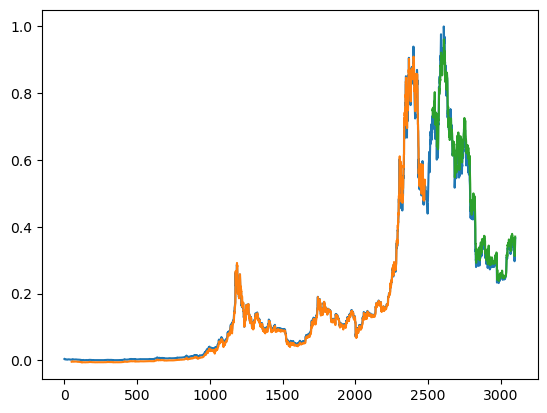

In [34]:
# plotting train predictions
look_back = 50
train_predict_plot = np.empty_like(bit_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[look_back : len(train_predict)+look_back, :] = train_predict
# plotting test predictions
test_predict_plot = np.empty_like(bit_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1 : len(df)-1, :] = test_predict
# plotting baselines and predictions
plt.plot(bit_data)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()